In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from random import seed
from random import randrange
import operator
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the imdb dataset
imdb_df = pd.read_csv('data/imdb_labelled.txt' , delimiter='\t', names=['review', 'sentiment'])
print(imdb_df.shape)

# loading the amazon dataset
amazon_df = pd.read_csv('data/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['review', 'sentiment'])
print(amazon_df.shape)

# loading the yelp dataset
yelp_df = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', header=None, names=['review', 'sentiment'] )
print(yelp_df.shape)

(748, 2)
(1000, 2)
(1000, 2)


In [3]:
dataset = imdb_df
dataset.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     748 non-null    object
 1   sentiment  748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [5]:
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
dataset.sentiment.value_counts()

1    386
0    362
Name: sentiment, dtype: int64

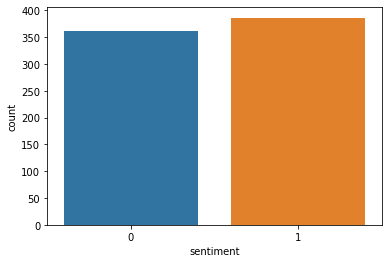

In [7]:
sns.countplot(x='sentiment', data=dataset)
plt.show()

In [8]:
def remove_special_characters(text):

    text = text.replace('-', ' ')
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    text = text.replace(' +', '')
    
    pattern = r'[^a-zA-z\s]'
    
    text = re.sub(pattern, '', text)
    text = text.rstrip()

    return text

dataset['review'] = dataset['review'].apply(remove_special_characters)
# text = '.'.join(dataset.review)
# text

In [9]:
# divide the dataset into train, development & test
# first the train & test data with 80 & 20 ratio
ratio = 0.8

train_len = int(ratio * len(dataset))
total_train_data = dataset[0:train_len]
test_dataset = dataset[train_len:]

# now divide into val dataset from training dataset with 80 & 20 ratio
new_train_len = int(ratio * len(total_train_data))

train_dataset = total_train_data[0:new_train_len]
val_dataset = total_train_data[new_train_len:]

print(f'training data shape: {train_dataset.shape}')
print(f'validation/development data shape: {val_dataset.shape}')
print(f'testing data shape: {test_dataset.shape}')

training data shape: (478, 2)
validation/development data shape: (120, 2)
testing data shape: (150, 2)


In [10]:
# dataset = dataset.sample(len(dataset))

In [11]:
X_train = train_dataset['review']
y_train = train_dataset['sentiment']
# X_train.shape

X_val = val_dataset['review']
y_val = val_dataset['sentiment']
# X_val.shape

X_test = test_dataset['review']
y_test = test_dataset['sentiment']
# X_test.shape

0 - Negative Review
1 - Positive Review

### **3. Calculate prior probabilities**

In [12]:
review_0_train = train_dataset.loc[train_dataset.sentiment == 0]
print(f'Total 0 (negative) review in train dataset : {len(review_0_train)}')

review_1_train = train_dataset.loc[train_dataset.sentiment == 1]
print(f'Total 1 (positive) review in train dataset : {len(review_1_train)}')

Total 0 (negative) review in train dataset : 267
Total 1 (positive) review in train dataset : 211


In [13]:
# let's calculate the prior class (0 & 1) probabilities
def calculate_prior_class_prob(y_train):
  prior_class_prob = {}
  for c in np.unique(y_train):
    count = sum(y_train == c)
    prior_class_prob[c] = count / y_train.size
  return prior_class_prob

prior_class_prob = calculate_prior_class_prob(y_train)
print(f'prior probability of class 0 (negative) : {prior_class_prob[0]}')
print(f'prior probability of class 1 (positive) : {prior_class_prob[1]}')

prior probability of class 0 (negative) : 0.5585774058577406
prior probability of class 1 (positive) : 0.44142259414225943


In [14]:
def tokenize(sentence):
  vocab = []
  word_freq = {}
  for word in sentence.split(' '):
    word = word.lower()
    if word not in word_freq.keys():
      word_freq[word] = 1
      vocab.append(word)
    else:
      word_freq[word] += 1
  
  return vocab, word_freq

In [15]:
stop_words_list = ['those', 'on', 'own', 'yourselves', 'ie', 'around', 'between', 
                   'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 
                   'cry', 'regarding', 'hereafter', 'front', 'too', 'used', 
                   'wherein', 'doing', 'everything', 'up', 'never', 'onto', 'how', 
                   'either', 'before', 'anyway', 'since', 'through', 'amount', 
                   'now', 'he', 'cant', 'was', 'con', 'have', 'into', 'because', 
                   'inc', 'not', 'therefore', 'they', 'even', 'whom', 'it', 'see', 
                   'somewhere', 'interest', 'thereupon', 'thick', 'nothing', 
                   'whereas', 'much', 'whenever', 'find', 'seem', 'until', 
                   'whereby', 'at', 'ltd', 'fire', 'also', 'some', 'last', 'than', 
                   'get', 'already', 'our', 'doesn', 'once', 'will', 'noone', 
                   'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 
                   'although', 'though', 'etc', 'which', 'would', 'therein', 'nor', 
                   'somehow', 'whereupon', 'besides', 'whoever', 'thin', 'ourselves', 
                   'few', 'did', 'third', 'without', 'twelve', 'anything', 'against', 
                   'while', 'twenty', 'if', 'however', 'found', 'herself', 'when', 
                   'may', 'six', 'ours', 'done', 'seems', 'else', 'call', 'perhaps', 
                   'had', 'nevertheless', 'fill', 'where', 'otherwise', 'still', 
                   'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 
                   'of', 'eg', 'others', 'show', 'sincere', 'anywhere', 'anyhow', 
                   'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 
                   'latterly', 'de', 'say', 'does', 'neither', 'his', 'go', 'forty', 
                   'put', 'their', 'by', 'namely', 'km', 'could', 'five', 'unless', 
                   'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 
                   'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 
                   'every', 'thru', 'except', 'very', 'several', 'among', 'being', 
                   'be', 'mine', 'further', 'here', 'during', 'why', 'with', 'just', 
                   'becomes', 'about', 'a', 'co', 'using', 'seeming', 'due', 
                   'wherever', 'beforehand', 'detail', 'fifty', 'becoming', 'might', 
                   'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 
                   'least', 'someone', 'often', 'from', 'keep', 'him', 'or', 'top', 
                   'her', 'didn', 'nobody', 'sometime', 'across', 'hundred', 'only', 
                   'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 
                   'me', 'we', 'formerly', 'so', 'i', 'whence', 'describe', 'under', 
                   'always', 'himself', 'more', 'herein', 'in', 'after', 'themselves', 
                   'you', 'them', 'above', 'sixty', 'hasnt', 'your', 'made', 'everywhere', 
                   'indeed', 'most', 'kg', 'fifteen', 'but', 'must', 'along', 'beside', 
                   'hers', 'computer', 'side', 'former', 'full', 'anyone', 'has', 'yours', 
                   'whose', 'behind', 'please', 'mill', 'amoungst', 'ten', 'seemed', 
                   'sometimes', 'should', 'over', 'take', 'each', 'don', 'same', 
                   'rather', 'really', 'latter', 'and', 'part', 'hereupon', 'per', 
                   'eleven', 'ever', 'enough', 'again', 'us', 'yet', 'moreover', 
                   'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', 'give', 
                   'system', 'do', 'quite', 'an', 'these', 'everyone', 'towards', 'this', 
                   'bill', 'cannot', 'un', 'afterwards', 'beyond', 'make', 'were', 
                   'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 
                   'none', 'many', 'various', 'serious', 're', 'two', 'less', 'couldnt', 'so', 'didnt', '']


def remove_stop_words(v, wf):
  for w in v:
    if w in stop_words_list:
      del wf[w]
      v.remove(w)
  return v, wf

In [16]:
# build the vocabulary as list
def tokenize_all(data):
  vocab = []
  word_freq = {}
  for i in range(len(data)):
    for sentence in data:
      sentence = remove_special_characters(sentence)
      for word in sentence.split(' '):
        word = word.lower()
        if word not in word_freq.keys():
          word_freq[word] = 1
          vocab.append(word)
        else:
          word_freq[word] += 1
  
  return vocab, word_freq

vocab, word_freq = tokenize_all(X_train)
vocab, word_freq = remove_stop_words(vocab, word_freq)
print(f"Total no of Review Vocab/Features : {len(vocab)}")

vocab_0, word_freq_0 = tokenize_all(review_0_train.review)
vocab_0, word_freq_0 = remove_stop_words(vocab_0, word_freq_0)
print(f"Total no of Negative Review Vocab/Features : {len(vocab_0)}")

vocab_1, word_freq_1 = tokenize_all(review_1_train.review)
vocab_1, word_freq_1 = remove_stop_words(vocab_1, word_freq_1)
print(f"Total no of Positive Review Vocab/Features : {len(vocab_1)}")

Total no of Review Vocab/Features : 2174
Total no of Negative Review Vocab/Features : 1490
Total no of Positive Review Vocab/Features : 1067


### **Calculate conditional probabilities based on sentiments**

In [17]:
def conditional_probability(word_freq_0, word_freq_1):
  word_freq_0_probs = {}
  word_freq_1_probs = {}

  for word in word_freq_0:
    word_freq_0_probs[word] = word_freq_0[word] / len(word_freq_0)

  for word in word_freq_1:
    word_freq_1_probs[word] = word_freq_1[word] / len(word_freq_1)

  return word_freq_0_probs, word_freq_1_probs

word_freq_0_probs, word_freq_1_probs = conditional_probability(word_freq_0, word_freq_1)
print(word_freq_0_probs)
print(word_freq_1_probs)

{'very': 5.913422818791946, 'slow': 0.5375838926174497, 'moving': 0.35838926174496644, 'aimless': 0.17919463087248322, 'movie': 13.977181208053691, 'distressed': 0.17919463087248322, 'drifting': 0.17919463087248322, 'young': 0.35838926174496644, 'man': 0.8959731543624161, 'sure': 0.5375838926174497, 'was': 17.74026845637584, 'lost': 0.17919463087248322, 'the': 65.76442953020134, 'flat': 0.35838926174496644, 'characters': 2.508724832214765, 'audience': 0.35838926174496644, 'nearly': 0.17919463087248322, 'half': 0.8959731543624161, 'whom': 0.35838926174496644, 'walked': 0.17919463087248322, 'attempting': 0.17919463087248322, 'artiness': 0.17919463087248322, 'black': 0.7167785234899329, 'white': 0.17919463087248322, 'clever': 0.35838926174496644, 'camera': 0.7167785234899329, 'angles': 0.17919463087248322, 'disappointed': 0.7167785234899329, 'even': 5.01744966442953, 'ridiculous': 0.7167785234899329, 'acting': 3.5838926174496644, 'poor': 1.0751677852348993, 'plot': 3.046308724832215, 'lin

In [18]:
def accuracy(actual, predicted):
  correct = 0
  for i in range(len(actual)):
    if actual[i] == predicted[i]:
      correct = correct + 1
  return correct / float(len(actual)) * 100.0

In [19]:
def fit(train_data):
  y_preds = []
  for sentence in train_data:
    vocab, word_freq = tokenize(sentence)
    vocab, word_freq = remove_stop_words(vocab, word_freq)

    word_freq_0_probs, word_freq_1_probs = conditional_probability(word_freq_0, word_freq_1)
    
    liklihood_0 = 1
    liklihood_1 = 1
    
    for word in vocab:
      if not word in word_freq_0_probs:
        word_freq_0_probs[word] = 0.0
      
      if not word in word_freq_1_probs:
        word_freq_1_probs[word] = 0.0
      
      liklihood_0 = liklihood_0 * word_freq_0_probs[word]
      liklihood_1 = liklihood_1 * word_freq_1_probs[word]

    posterior_0 = prior_class_prob[0]*liklihood_0
    posterior_1 = prior_class_prob[1]*liklihood_1
    
    if posterior_0 > posterior_1:
      preds = 0
    else:
      preds = 1
      
    y_preds.append(preds)
  return y_preds

model = fit(X_train)

train_accuracy = accuracy(model, y_train)
print(f'Accuracy on Train Dataset : {train_accuracy} %')

Accuracy on Train Dataset : 54.18410041841004 %


In [20]:
X_train.head()

0    A very very very slow moving aimless movie abo...
1    Not sure who was more lost   the flat characte...
2    Attempting artiness with black  white and clev...
3            Very little music or anything to speak of
4    The best scene in the movie was when Gerardo i...
Name: review, dtype: object

In [21]:
# a method to predict or test our model
def predict(test_data):
  predd = []
  for sentence in test_data:
    vocab, word_freq = tokenize(sentence)
    vocab, word_freq = remove_stop_words(vocab, word_freq)
    # print(f'Vocab : {vocab}, word freq : {word_freq}')
    liklihood_0 = 1
    liklihood_1 = 1
    for word in vocab:
      if not word in word_freq_0_probs:
        word_freq_0_probs[word] = 0.0
      
      if not word in word_freq_1_probs:
        word_freq_1_probs[word] = 0.0
      
      liklihood_0 = liklihood_0 * word_freq_0_probs[word]
      liklihood_1 = liklihood_1 * word_freq_1_probs[word]

    posterior_0 = prior_class_prob[0]*liklihood_0
    posterior_1 = prior_class_prob[1]*liklihood_1
    
    if posterior_0 > posterior_1:
        y_pred = 0
    else:
        y_pred = 1

    predd.append(y_pred)
  return predd

# test_pred = predict(X_test)

# test_accuracy = accuracy(y_test.to_list(), test_pred)
# print(f'Accuracy on Test Dataset : {test_accuracy} %')

### **d. Accuracy On validation/development dataset**

In [22]:
val_dataset.head()

,review,sentiment
478,Hes a national treasure,1
479,GO AND SEE IT,1
480,This is an excellent film,1
481,The aerial scenes were well done,1
482,It was also the right balance of war and love,1


In [23]:
# a method to split the dataset into given no of folds
def cross_validation_split(dataset, n_folds):
  dataset_split = []
  dataset_copy = dataset
  fold_size = int(len(dataset) / n_folds)
  for _ in range(n_folds):
    fold = []
    while len(fold) < fold_size:
      r = randrange(dataset_copy.shape[0])
      index = dataset_copy.index[r]
      fold.append(dataset_copy.loc[index].values.tolist())
      dataset_copy = dataset_copy.drop(index)
    dataset_split.append(fold)
  return dataset_split

In [24]:
# a method to split the cross fold data into training & test data and calculate accuracies on all folds
def kfold_cv(dataset, n_folds):
  dataset_split = cross_validation_split(dataset, n_folds)
  # print(np.array(dataset_split).shape)
  kfold_accuracies = []
  for i in range(n_folds):
    r = list(range(n_folds)) # [0, 1, 2, 3, 4]
    index = r.pop(i) # remove 1 fold data i:e test one
    cv_test = dataset_split[index]
    for j in r:
      # print("r[0]", r[0])
      if j == r[0]:
        cv_train = dataset_split[j]
      else:
        cv_train = np.concatenate((cv_train, dataset_split[j]), axis=0)
    cv_train = pd.DataFrame(cv_train, columns=['review', 'sentiment'])
    cv_test = pd.DataFrame(cv_test, columns=['review', 'sentiment'])
    # print(cv_dataset)
    fit(cv_train.review)
    cv_preds = predict(cv_test.review)
    cv_acc = accuracy(cv_test.sentiment, cv_preds)
    kfold_accuracies.append(cv_acc)
  return kfold_accuracies

In [25]:
kfold_accuracies = kfold_cv(val_dataset, 5)
print("Accuracies on 5 fold validation/development dataset : ", kfold_accuracies)

Accuracies on 5 fold validation/development dataset :  [66.66666666666666, 62.5, 62.5, 50.0, 54.166666666666664]


In [26]:
print("Before applying laplacian smoothing....")

test_pred = predict(X_test)

test_accuracy = accuracy(y_test.to_list(), test_pred)
print(f'Accuracy on Test Dataset : {test_accuracy} %')

Before applying laplacian smoothing....
Accuracy on Test Dataset : 68.0 %


## **Laplace/Additive Smoothing**

to handle the problem of Zero Probability

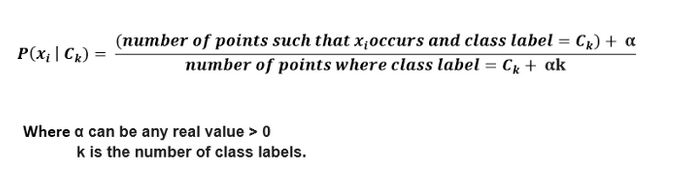

In [27]:
def laplace_conditional_probability(word_freq_0, word_freq_1, alpha):
  word_freq_0_probs = {}
  word_freq_1_probs = {}

  for word in vocab:

    for word in word_freq_0:
      word_freq_0_probs[word] = (word_freq_0[word] + 1) / (len(word_freq_0) + 2*alpha)

    for word in word_freq_1:
      word_freq_1_probs[word] = (word_freq_1[word] + 1) / (len(word_freq_1) + 2*alpha)

    return word_freq_0_probs, word_freq_1_probs

In [28]:
# apply laplacian smoothing 
def predict(test_data, alpha):
  predd = []
  for sentence in test_data:
    vocab, word_freq = tokenize(sentence)
    vocab, word_freq = remove_stop_words(vocab, word_freq)
    # print(f'Vocab : {vocab}, word freq : {word_freq}')
    liklihood_0 = 1
    liklihood_1 = 1
    
    for word in vocab:

      if not word in word_freq_0:
        word_freq_0[word] = 0
    
      if not word in word_freq_1:
        word_freq_1[word] = 0

      word_freq_0_probs, word_freq_1_probs = laplace_conditional_probability(word_freq_0, word_freq_1, alpha)

      liklihood_0 = liklihood_0 * word_freq_0_probs[word]
      liklihood_1 = liklihood_1 * word_freq_1_probs[word]

    posterior_0 = prior_class_prob[0]*liklihood_0
    posterior_1 = prior_class_prob[1]*liklihood_1
    
    if posterior_0 > posterior_1:
        y_pred=0
    else:
        y_pred=1
    
    # return y_pred
    predd.append(y_pred)
  return predd

In [29]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
lap_acc = []
for alpha in alpha_values:
  
  alpha_preds = predict(X_test, alpha)
  
  alpha_accuracy = accuracy(y_test.to_list(), alpha_preds)
  print(f'alpha = {alpha}, Accuracy = {alpha_accuracy} %')
  lap_acc.append(alpha_accuracy)

alpha = 0.0001, Accuracy = 50.0 %
alpha = 0.001, Accuracy = 50.0 %
alpha = 0.01, Accuracy = 50.0 %
alpha = 0.1, Accuracy = 50.0 %
alpha = 1, Accuracy = 50.0 %
alpha = 10, Accuracy = 50.0 %
alpha = 100, Accuracy = 48.0 %
alpha = 1000, Accuracy = 47.333333333333336 %
alpha = 10000, Accuracy = 46.0 %


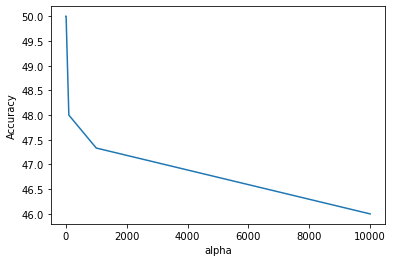

In [30]:
sns.lineplot(alpha_values, lap_acc)
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.show()

### **e. Top 10 words that predicts positive and negative class**

In [31]:
# gettting top 10 positive & negative words 
# top10_0 = dict(sorted(word_freq_0_probs.items(), key=operator.itemgetter(1),reverse=True)[:10])
# print(f'Top 10 Negative (0) words : {top10_0.keys()}')
# top10_1 = dict(sorted(word_freq_1_probs.items(), key=operator.itemgetter(1),reverse=True)[:10])
# print(f'Top 10 Positive (1) words : {top10_1.keys()}')

top10_0 = dict(sorted(word_freq_0_probs.items(), key=operator.itemgetter(1),reverse=True))
top10_1 = dict(sorted(word_freq_1_probs.items(), key=operator.itemgetter(1),reverse=True))
top10_neg = []
i = 0
for key, value in top10_0.items():
    if (key not in stop_words_list) & (i < 10):
        top10_neg.append(key)
        i = i+1
print(f'Top 10 Negative (0) words :\n {top10_neg}')

top10_pos = []
i = 0
for key, value in top10_1.items():
    if (key not in stop_words_list) & (i < 10):
        top10_pos.append(key)
        i = i+1
print(f'Top 10 Positive (1) words :\n {top10_pos}')

Top 10 Negative (0) words :
 ['movie', 'film', 'bad', 'acting', 'like', 'good', 'plot', 'time', 'characters', 'script']
Top 10 Positive (1) words :
 ['movie', 'film', 'good', 'great', 'best', 'funny', 'characters', 'dont', 'think', 'like']


### **f. Calculate final Accuracy on test dataset using optimal hyperparameter found in e**

**Best Alpha Value = 0.0001**

In [32]:
print("After applying laplace smoothing....")
alpha = 0.0001
test_pred = predict(X_test, alpha)

lap_test_accuracy = accuracy(y_test.to_list(), test_pred)
print(f'Final Accuracy on Test Dataset using Laplace smoothing : {lap_test_accuracy} %')

After applying laplace smoothing....
Final Accuracy on Test Dataset using Laplace smoothing : 50.0 %


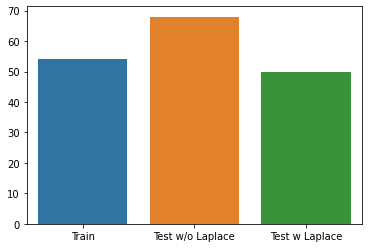

In [33]:
x = ['Train', 'Test w/o Laplace', 'Test w Laplace']
y = [train_accuracy, test_accuracy, lap_test_accuracy]
sns.barplot(x, y)
plt.show()

## References

https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb#scrollTo=szrrr5iE3oGj

https://pytorch.org/text/stable/datasets.html

https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/

https://medium.com/analytics-vidhya/naive-bayes-classifier-for-text-classification-556fabaf252b

http://datamine.unc.edu/jupyter/notebooks/Text%20Mining%20Modules/(1)%20Text%20Preprocessing.ipynb

https://www.coursera.org/lecture/classification-vector-spaces-in-nlp/laplacian-smoothing-2jMPy

https://machinelearningmastery.com/implement-machine-learning-algorithm-performance-metrics-scratch-python/

https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

https://machinelearningmastery.com/implement-resampling-methods-scratch-python/

https://scikit-learn.org/stable/modules/cross_validation.html

https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/


https://www.kaggle.com/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch/notebook

https://stackoverflow.com/questions/7197315/5-maximum-values-in-a-python-dictionary

https://stackoverflow.com/questions/29270917/removing-custom-stop-words-form-a-phrase-in-python

https://medium.com/@sanjeethboddi/naive-bayes-algorithm-from-scratch-715d7cc0de53

https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

